In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from funfact.rbf import RBFExpansionDenseFullGrad

# Run the RBF expansion

In [2]:
np.random.seed(0)
target = np.random.normal(0.0, 1.0, (12, 24))

In [3]:
fac = RBFExpansionDenseFullGrad(r=6, ensemble_size=8, max_steps=5000)

In [4]:
fac.fit(target)

100%|██████████| 5000/5000 [00:05<00:00, 995.80it/s] 


In [5]:
fac.optimum

<ensemble of 8 RBF expansions [x_names = u, v, a, b]>

# Access individual components

In [6]:
fac.optimum.x_names

['u', 'v', 'a', 'b']

In [7]:
print('u   -->   {:>14s}  *  {:>14s}  *  {:>14s}'.format('n_rows', 'n_rbf_terms', 'ensemble_size'))
print('    -->   {:>14d}  *  {:>14d}  *  {:>14d}'.format(*fac.optimum.u.shape))

u   -->           n_rows  *     n_rbf_terms  *   ensemble_size
    -->               12  *               6  *               8


In [8]:
print('v   -->   {:>14s}  *  {:>14s}  *  {:>14s}'.format('n_cols', 'n_rbf_terms', 'ensemble_size'))
print('    -->   {:>14d}  *  {:>14d}  *  {:>14d}'.format(*fac.optimum.v.shape))

v   -->           n_cols  *     n_rbf_terms  *   ensemble_size
    -->               24  *               6  *               8


In [9]:
print('a   -->   {:>14s}  *  {:>14s}'.format('n_rbf_terms', 'ensemble_size'))
print('    -->   {:>14d}  *  {:>14d}'.format(*fac.optimum.a.shape))

a   -->      n_rbf_terms  *   ensemble_size
    -->                6  *               8


In [10]:
print('b   -->   {:>14s}'.format('ensemble_size'))
print('    -->   {:>14d}'.format(*fac.optimum.b.shape))

b   -->    ensemble_size
    -->                8


In [11]:
# Take the 2nd component of the 0th run
print(fac.optimum.u[..., 2, 0])
print(fac.optimum.v[..., 2, 0])
print(fac.optimum.a[..., 2, 0])
print(fac.optimum.b[0])  # b is a per-run offset value

[-1.6153973  0.4826357  5.991309   3.9733694 -3.0490656 -3.0875394
 -8.550724   8.344959  -2.7368     3.7523944 -4.6583138 -8.246275 ]
[-2.0958087   6.8209834   2.8851976   5.152407   -0.5445912   1.0080318
  2.8303766  -3.1490636  -0.72391456 -9.745661    3.112193    1.3936749
  4.8447976   4.593044   -2.0263429  -1.003689   -0.93587023  5.002834
 -2.214689    5.52318     2.1721466  -5.6474276  -1.5170404  -3.9085846 ]
2.3396478
-1.387726


## Copy values between runs

In [12]:
# copy 'u' from run 6 to run 5
fac.optimum.u[..., 5] = fac.optimum.u[..., 6]

In [13]:
# copy a component of 'v' from run 0 to run 6
fac.optimum.v[..., 1, 0] = fac.optimum.v[..., 1, 6]

## Obtain reconstructed matrices

In [14]:
# all runs
fac.optimum().shape

(12, 24, 8)

In [15]:
best_run = np.argmin(fac.report.loss_best)
print('best run is', best_run)

best run is 3


In [16]:
# only the second run
fac.optimum(runs=best_run).shape

(12, 24)

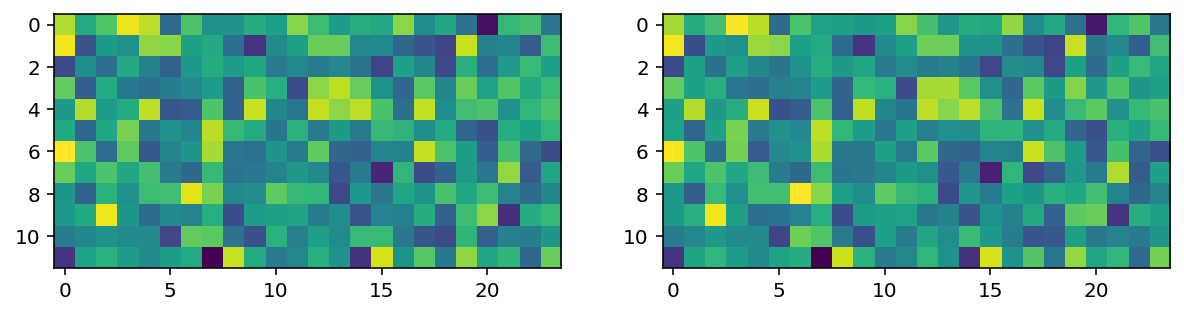

In [17]:
# visualize one of the runs
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(target)
axs[1].imshow(fac.optimum(runs=best_run))
plt.show()

In [18]:
# multiple runs
print(fac.optimum(runs=best_run).shape)
print(fac.optimum(runs=[best_run]).shape)
print(fac.optimum(runs=[best_run, 5]).shape)
print(fac.optimum(runs=range(4)).shape)

(12, 24)
(12, 24, 1)
(12, 24, 2)
(12, 24, 4)


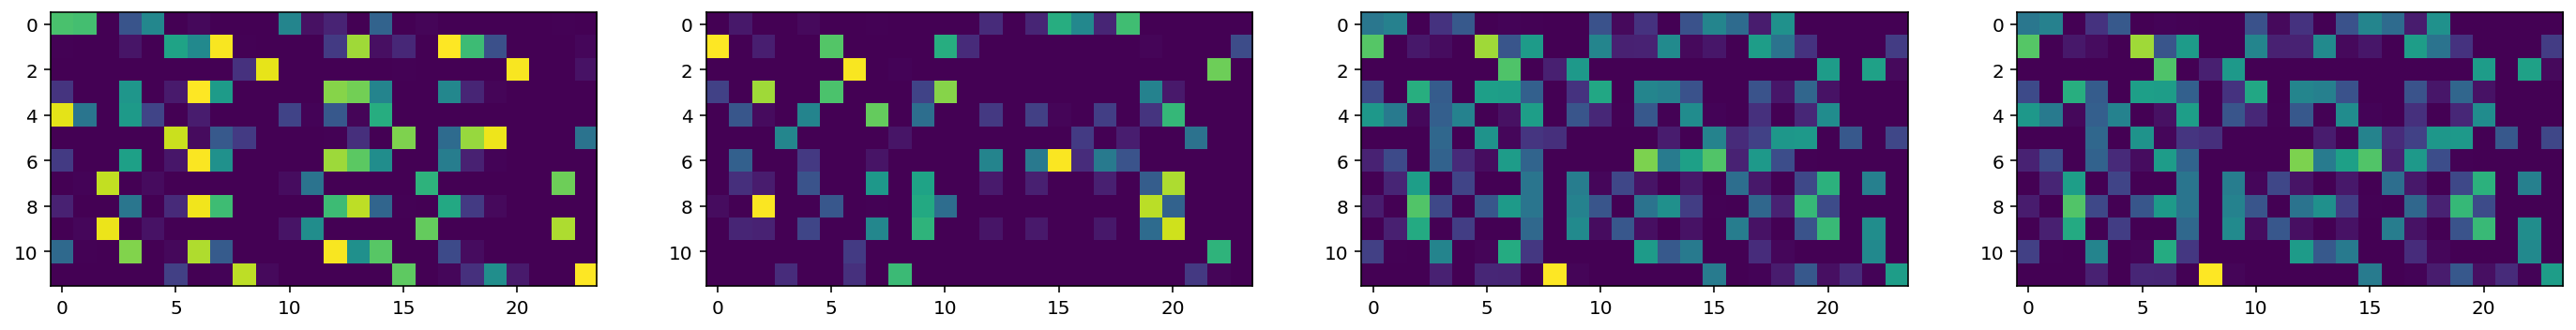

In [19]:
# reconstruct select components only
fig, axs = plt.subplots(1, 4, figsize=(24, 4))
axs[0].imshow(fac.optimum(runs=best_run, components=0))
axs[1].imshow(fac.optimum(runs=best_run, components=1))
axs[2].imshow(fac.optimum(runs=best_run, components=0) +
              fac.optimum(runs=best_run, components=1))
axs[3].imshow(fac.optimum(runs=best_run, components=[0, 1]))
plt.show()

## History

In [20]:
fac.report.loss_history.shape  # history of loss for all runs

(5000, 8)

In [21]:
fac.report.loss_best  # best loss for each run

array([0.05173542, 0.04616789, 0.03761928, 0.02738015, 0.08305205,
       0.0290204 , 0.03017904, 0.02807069], dtype=float32)

In [22]:
fac.report.t_best  # timestamp of when each run achieved its own best result

array([4993, 4982, 4831, 4983, 4984, 4971, 4983, 4932])

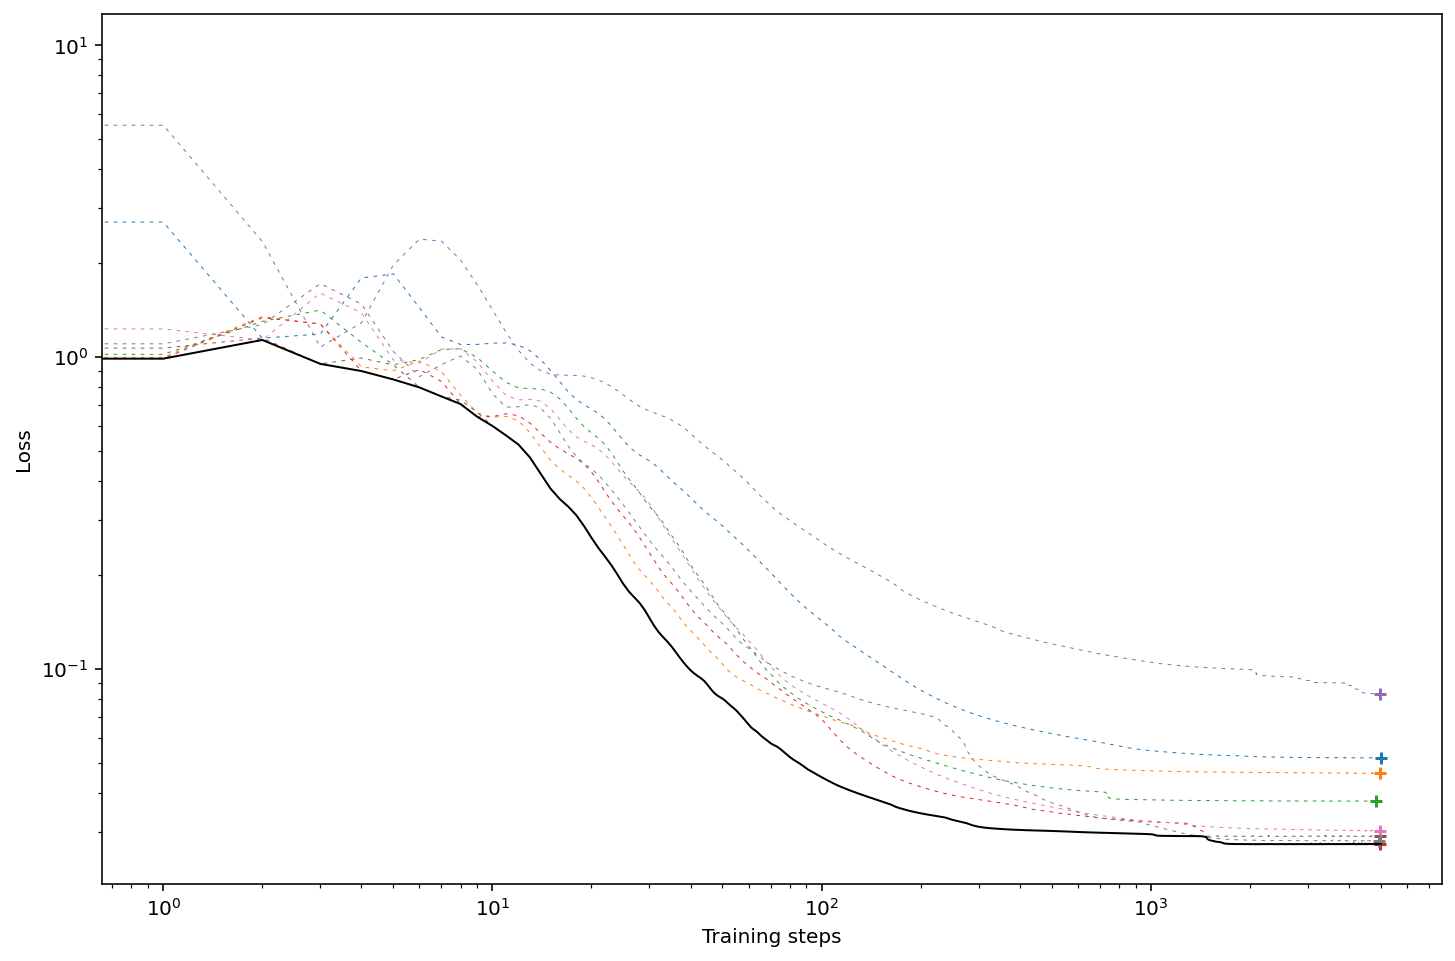

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(fac.report.loss_history, lw=0.5, ls=(2,(3, 6)), dash_capstyle='round')
plt.plot(fac.report.loss_history.min(axis=1), lw=1, color='k', dash_capstyle='round')
for h, t in zip(fac.report.loss_history.T, fac.report.t_best):
    plt.scatter(t, h[t], marker='+')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Continue after small perturbation

In [24]:
fac2 = RBFExpansionDenseFullGrad(**fac.config)

In [25]:
fac2.fit(
    target,
    u0=fac.optimum.u + 0.1 * np.random.randn(*fac.optimum.u.shape),
    v0=fac.optimum.v,
    a0=fac.optimum.a,
    b0=fac.optimum.b
)

100%|██████████| 5000/5000 [00:04<00:00, 1022.11it/s]


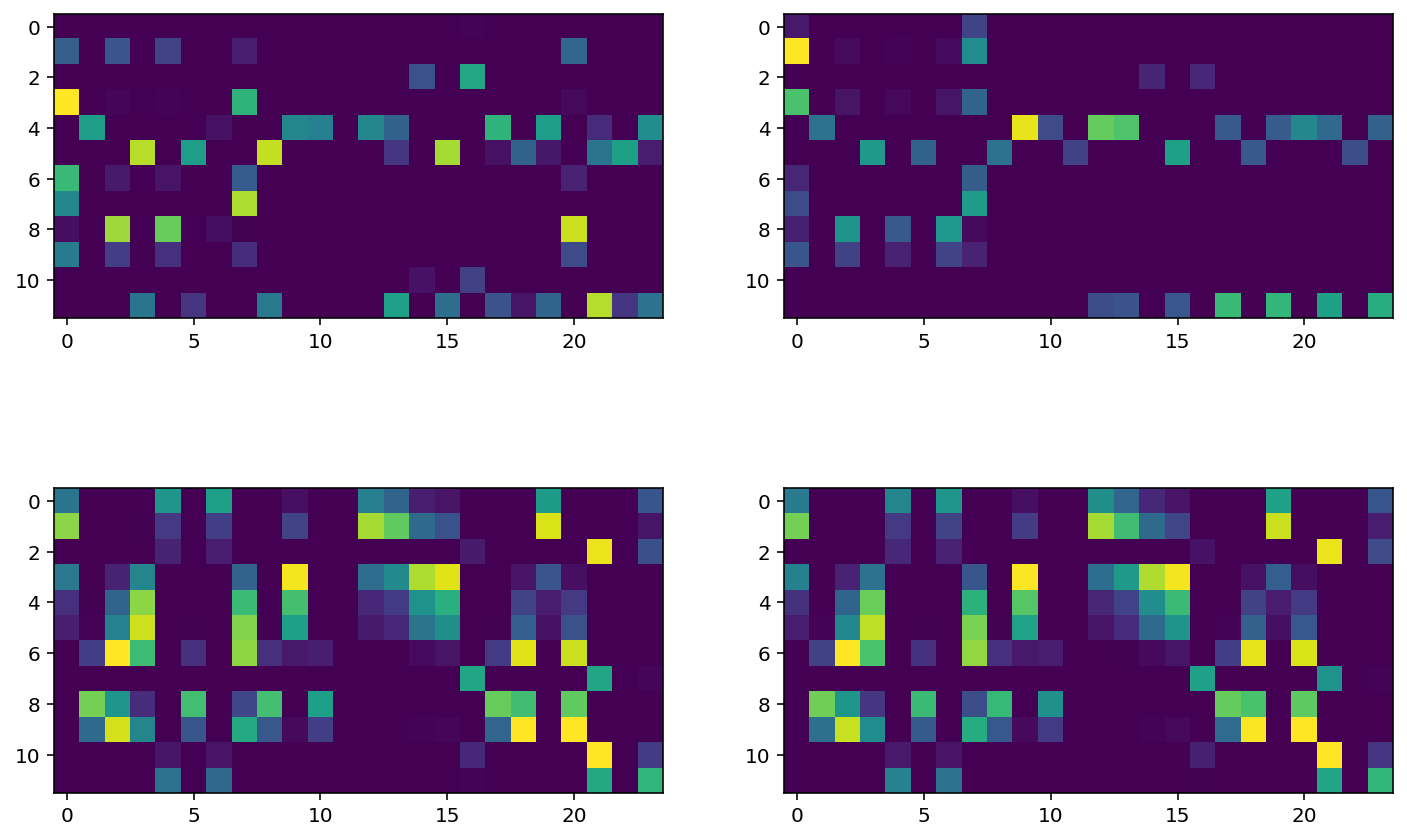

In [26]:
# compare result with the original factorization
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].imshow(fac.optimum(runs=0, components=0))
axs[1, 0].imshow(fac.optimum(runs=1, components=0))
axs[0, 1].imshow(fac2.optimum(runs=0, components=0))
axs[1, 1].imshow(fac2.optimum(runs=1, components=0))
plt.show()

# Symmetric factorization

In [27]:
target = np.random.normal(0.0, 1.0, (16, 16))
target = 0.5 * (target + target.T)
fac3 = RBFExpansionDenseFullGrad(r=6, ensemble_size=8, max_steps=5000)
fac3.fith(target)

100%|██████████| 5000/5000 [00:04<00:00, 1008.14it/s]


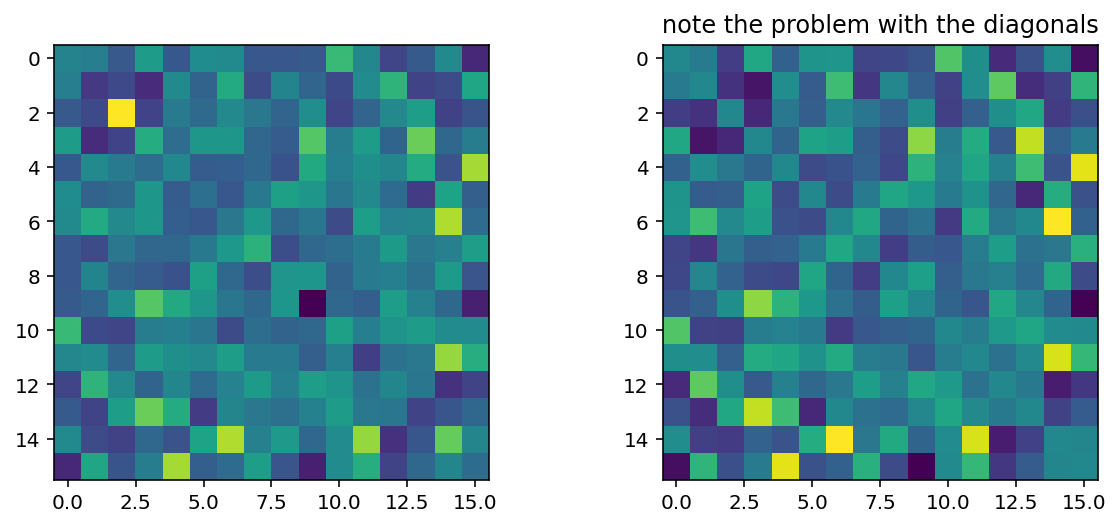

In [28]:
# visualize one of the runs
# note the problem with the diagonals
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(target)
axs[1].imshow(fac3.optimum(runs=np.argmin(fac3.report.loss_best)))
axs[1].set_title('note the problem with the diagonals')
plt.show()

END
---